## Supplementary Figure - 2019 Bid Stack
Siobhan Powell, 2021.

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import pickle

In [3]:
from simple_dispatch import bidStack
import matplotlib
import scipy
from future_grid import FutureDemand

In [4]:
unit_drops = pd.read_csv('IntermediateOutputs/scheduled_retirements_2019.csv', index_col=0)
additions_df = pd.read_csv('IntermediateOutputs/generator_additions.csv', index_col=0)
import copy
def drop_add_generators(future_year, gd_short_init, unit_drops=None, additions_df=None, drop=True, add=True):
    
    gd_short_final = copy.deepcopy(gd_short_init)
    if add:
        added_units = additions_df[additions_df['Year']<future_year]['orispl_unit'].values
        for i, val in enumerate(added_units):
            idx = len(gd_short_final.df)
            loc1 = gd_short_final.df[gd_short_final.df['orispl_unit']==val].index
            gd_short_final.df = pd.concat((gd_short_final.df, gd_short_final.df.loc[loc1]), ignore_index=True)
            gd_short_final.df.loc[idx, 'orispl_unit'] = 'added_'+str(i)
        
    if drop:
        dropped_units = unit_drops[unit_drops['retirement_year']<future_year]['orispl_unit'].values
        gd_short_final.df = gd_short_final.df[~gd_short_final.df['orispl_unit'].isin(dropped_units)].copy(deep=True).reset_index(drop=True)
    
    return gd_short_final

In [5]:
year = 2019; run_year=2019
gd_short = pickle.load(open('IntermediateOutputs/generator_data_short_%s_%s.obj'%('WECC', str(run_year)), 'rb'))
# gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)

# Plotting

In [6]:
def plotBidStackMultiColor4(self, df_column, ax=None, xlim=93, save_str=None, show_legend=True, show_fig=True, xlab=False):    
    
    # adapted from Thomas Deetjen's code : https://github.com/tdeetjen/simple_dispatch
    
    bs_df_fuel_color = self.df.copy()
    
    # Add column "fuel_color" to dataframe based on fuel type for each generator
    legend_mapping = {'sub_st':'Subbituminous Coal', 'ng_ct':'Natural Gas Combined Cycle', 
                      'ng_gt':'Natural Gas Combustion Turbine', 'ng_st':'Natural Gas Boiler', 
                      'rc_st':'Refined Coal', 'bit_st':'Bituminous Coal', '_':'Other'}
    c = {'ng': {'cc': '#377eb8', 'ct': '#377eb8', 'gt': '#4daf4a', 'st': '#984ea3'}, 'sub': {'st': '#e41a1c'}, 'lig': {'st': '#ffff33'}, 'bit': {'st': '#ff7f00'}, 'rc': {'st': '#252525'}}
    bs_df_fuel_color['fuel_color'] = '#bcbddc'
    for c_key in c.keys():
        for p_key in c[c_key].keys():
            bs_df_fuel_color.loc[(bs_df_fuel_color.fuel == c_key) & (bs_df_fuel_color.prime_mover == p_key), 'fuel_color'] = c[c_key][p_key]
        empty_color = '#dd1c77'
        color_2 = bs_df_fuel_color.fuel_color.replace('', empty_color)
        
    # prepare y depending on whether plotting cost or emissions
    y_data_e = self.df.gen_cost * 0
    if df_column == 'gen_cost':
        y_lab = 'Generation Cost [$/MWh]'
        y_data = self.df[df_column] - (self.df.co2_cost + self.df.so2_cost + self.df.nox_cost) #cost excluding emissions taxes
    if df_column == 'co2':
        y_lab = 'CO$_2$ Emissions [kg/MWh]'
        y_data = self.df[df_column + str(self.time)]

    # plot
    if ax is None:
        f, ax = matplotlib.pyplot.subplots(figsize=(4, 4))
    # Bar chart: width of each is the capacity. Shift position by one indice so that the bar lines up to the left of its capacity. E.g. if the first one has capacity 10, the bar goes from 0 to 10 and the following bar starts from 10. 
    ax.bar((self.df['mw' + str(self.time)].cumsum()[:-1])/1000, height=y_data.values[1:], width=(self.df['mw' + str(self.time)].values[1:])/1000, color=color_2.values[1:], align='edge')
    if show_legend:
        color_legend = []
        for c in ['#e41a1c', '#ff7f00', '#252525', '#377eb8', '#4daf4a', '#984ea3', '#bcbddc']:#bs_df_fuel_color.fuel_color.unique():
            color_legend.append(matplotlib.patches.Patch(color=c, label=legend_mapping[bs_df_fuel_color.fuel[bs_df_fuel_color.fuel_color==c].iloc[0] + '_' + bs_df_fuel_color.prime_mover[bs_df_fuel_color.fuel_color==c].iloc[0]]))
        ax.legend(handles=color_legend, loc='upper left', ncol=1, fontsize=11)
    ax.set_xlim(0, xlim)
    if df_column == 'gen_cost':
        ax.set_ylim(0, 90)
        ax.set_yticks((0, 15, 30, 45, 60, 75, 90))
        ax.set_yticklabels((0, 15, 30, 45, 60, 75, 90), fontsize=14)
    elif df_column == 'co2':
        ax.set_ylim(0, 1400)
        ax.set_yticks((250, 500, 750, 1000, 1250))
        ax.set_yticklabels((250, 500, 750, 1000, 1250), fontsize=14)
    if xlab:
        ax.set_xlabel('Generation Capacity [GW]', fontsize=14)
        ax.set_xticklabels((0, 10, 20, 30, 40, 50, 60, 70, 80), fontsize=14)
    else:
        ax.set_xticklabels([])
    ax.set_xticks((0, 10, 20, 30, 40, 50, 60, 70, 80))
    ax.set_ylabel(y_lab, fontsize=14)
    
    ax.set_axisbelow(True)        
    ax.grid()

    plt.tight_layout()
    if save_str is not None:
        plt.savefig(save_str, bbox_inches='tight')
    if show_fig:
        plt.show()
        
    
    return ax


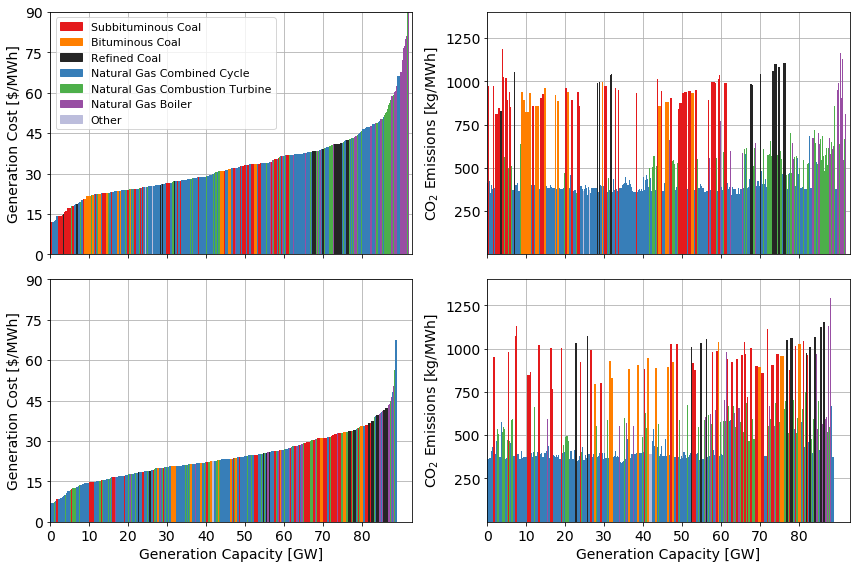

In [7]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True)
bs = bidStack(gd_short, co2_dol_per_kg=0, time=1, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[0, 0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[0, 0], show_legend=True, show_fig=False)
axes[0, 1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[0, 1], show_legend=False, show_fig=False)
bs = bidStack(gd_short, co2_dol_per_kg=0, time=27, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[1, 0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[1, 0], show_legend=False, show_fig=False, xlab=True)
axes[1, 1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[1, 1], show_legend=False, show_fig=True, xlab=True, 
                                     save_str='SupplementPlotting/Plots/supfig21_v2.pdf')


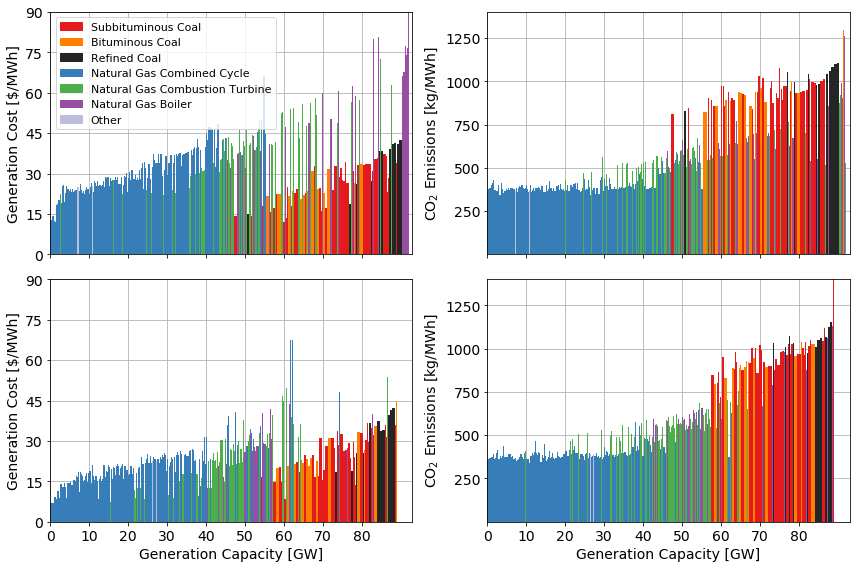

In [7]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True)
bs = bidStack(gd_short, co2_dol_per_kg=0.1, time=1, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[0, 0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[0, 0], show_legend=True, show_fig=False)
axes[0, 1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[0, 1], show_legend=False, show_fig=False)
bs = bidStack(gd_short, co2_dol_per_kg=0.1, time=27, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[1, 0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[1, 0], show_legend=False, show_fig=False, xlab=True)
axes[1, 1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[1, 1], show_legend=False, show_fig=True, xlab=True, 
                                     save_str='carbonprice0.1_2019grid.pdf')


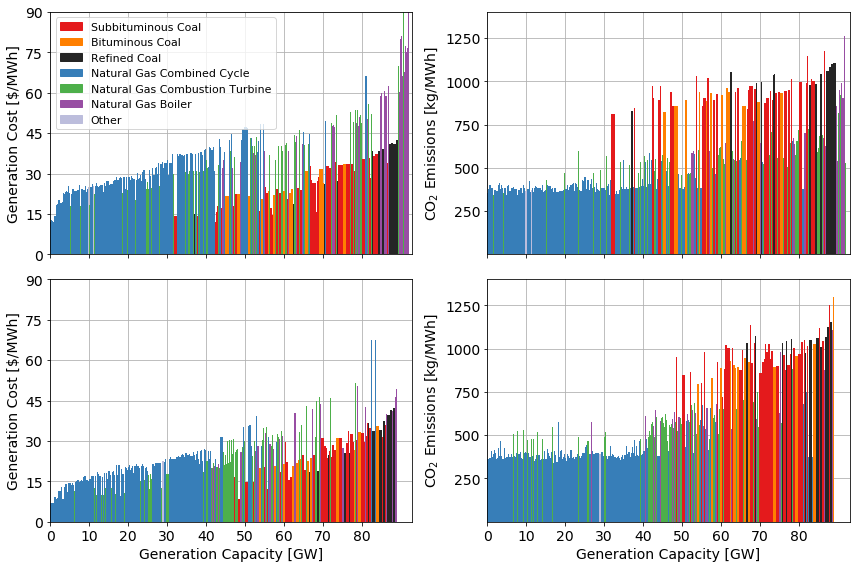

In [8]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True)
bs = bidStack(gd_short, co2_dol_per_kg=0.05, time=1, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[0, 0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[0, 0], show_legend=True, show_fig=False)
axes[0, 1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[0, 1], show_legend=False, show_fig=False)
bs = bidStack(gd_short, co2_dol_per_kg=0.05, time=27, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
axes[1, 0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[1, 0], show_legend=False, show_fig=False, xlab=True)
axes[1, 1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[1, 1], show_legend=False, show_fig=True, xlab=True, 
                                     save_str='carbonprice0.05_2019grid.pdf')
